## **Importing libraries**

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


## **Loading data**

In [ ]:
def load_data_from_folder(folder_path, label):
    data_list = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        data = np.loadtxt(file_path)
        data_list.append(data)
    data_array = np.vstack(data_list)
    labels = np.array([label] * data_array.shape[0])
    return data_array, labels


paths = {
    'A': '/content/drive/MyDrive/bonn_dataset/Z', # Class 0: Healthy with eyes open
    'B': '/content/drive/MyDrive/bonn_dataset/O', # Class 1: Healthy with eyes closed
    'C': '/content/drive/MyDrive/bonn_dataset/N', # Class 2: Seizure-free intervals from the hippocampal formation
    'D': '/content/drive/MyDrive/bonn_dataset/F', # Class 3: Seizure activity
    'E': '/content/drive/MyDrive/bonn_dataset/S'  # Class 4: Seizure activity
}

def prepare_data_for_classification(classes):
    X, y = [], []
    for label, class_id in enumerate(classes):
        folder_path = paths[class_id]
        data, labels = load_data_from_folder(folder_path, label)
        X.append(data)
        y.append(labels)
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

In [ ]:
def create_cnn_lstm_model(input_shape, filters, kernel_size, pool_size, lstm_units1, lstm_units2):
    model = Sequential() # Creates a Sequential model, which is a linear stack of layers.

    # Convolutional layer
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape)) # Adds a 1D convolutional layer to the model for feature extraction.
    model.add(MaxPooling1D(pool_size=pool_size)) # Adds a max pooling layer to downsample the feature maps.

    # LSTM layers
    model.add(LSTM(units=lstm_units1, return_sequences=True)) # Adds the first LSTM layer with the specified number of units and returns sequences for the next LSTM layer.
    model.add(LSTM(units=lstm_units2)) # Adds the second LSTM layer with the specified number of units.

    # Dense layer for binary classification
    model.add(Dense(units=1, activation='sigmoid'))  # Adds a dense layer with a sigmoid activation for binary classification.

    # Compile the model with binary crossentropy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compiles the model with the Adam optimizer, binary crossentropy loss, and accuracy metric.

    return model # Returns the compiled CNN-LSTM model.

In [ ]:
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)

    # Sensitivity (Recall for the positive class, assuming 1 is the positive label)
    sensitivity = recall_score(y_true, y_pred, pos_label=1)

    # Specificity (Recall for the negative class, assuming 0 is the negative label)
    specificity = recall_score(y_true, y_pred, pos_label=0)

    # F1 score
    f1 = f1_score(y_true, y_pred)

    return accuracy, sensitivity, specificity, f1


In [ ]:
def train_and_evaluate_cnn_lstm_model(X_train, y_train, X_test, y_test, filters, kernel_size, pool_size, lstm_units1, lstm_units2, batch_size, epochs):
    # Create the model
    model = create_cnn_lstm_model((X_train.shape[1], 1), filters, kernel_size, pool_size, lstm_units1, lstm_units2)

    # Display the model architecture
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)

    # Predict on test data
    y_pred_prob = model.predict(X_test)
    y_pred_labels = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    # Compute additional metrics (sensitivity, specificity, F1 score)
    accuracy, sensitivity, specificity, f1 = compute_metrics(y_test, y_pred_labels)
    print(f'Accuracy: {accuracy}')
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'F1 Score: {f1}')

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

    # Confusion matrix as heatmap
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return history, score

AB - CDE

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4095, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2047, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 2047, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,785 (901.50 KB)

 Trainable params: 230,785 (901.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 94s 8s/step - accuracy: 0.5962 - loss: 0.6549 - val_accuracy: 0.6000 - val_loss: 0.5986
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 0.6215 - loss: 0.6110 - val_accuracy: 0.6000 - val_loss: 0.5678
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.5352 - loss: 0.6146 - val_accuracy: 0.5875 - val_loss: 0.5573
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.5303 - loss: 0.5877 - val_accuracy: 0.6875 - val_loss: 0.5146
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.5517 - loss: 0.6360 - val_accuracy: 0.6375 - val_loss: 0.6043
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.5506 - loss: 0.6067 - val_accuracy: 0.6000 - val_loss: 0.5327
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.5776 - loss: 0.5744 - val_accuracy: 0.6000 - val_loss: 0.5455
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.5715 - loss: 0.5784 - val_accuracy: 0.6125 - val_loss

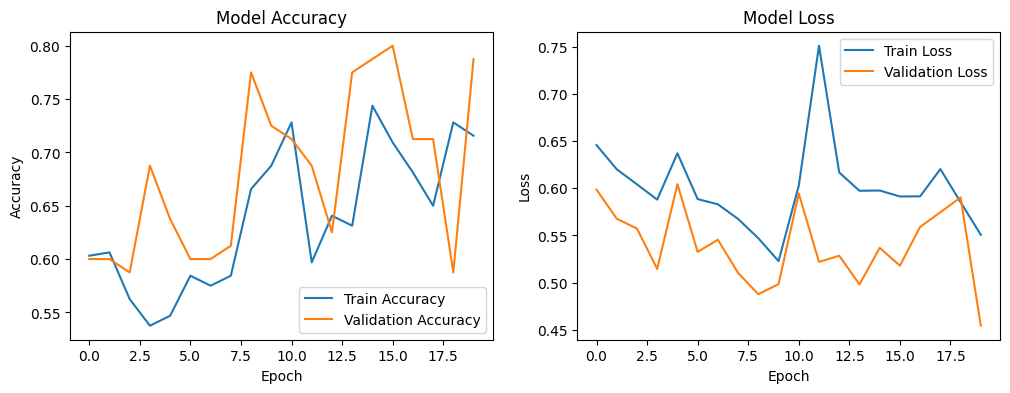

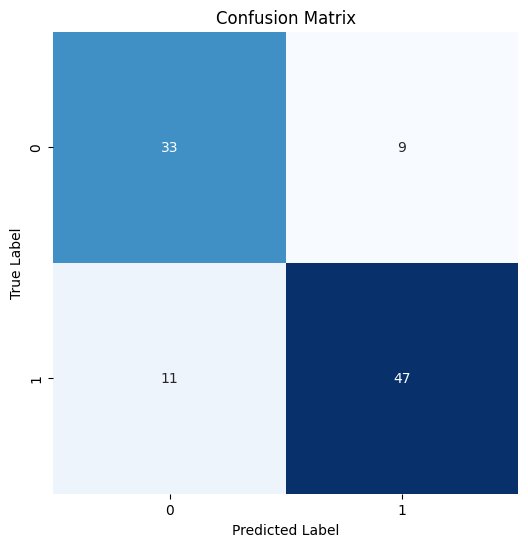

(<keras.src.callbacks.history.History at 0x7b2d5090a320>,
 [0.4652131199836731, 0.800000011920929])

In [ ]:
# Load and preprocess data for classes A-B vs. C-D-E
classes_ab = ['A', 'B']
classes_cde = ['C', 'D', 'E']
X_ab, y_ab = prepare_data_for_classification(classes_ab)
X_cde, y_cde = prepare_data_for_classification(classes_cde)

# Merge and create new binary labels
X = np.concatenate([X_ab, X_cde])
y = np.concatenate([np.zeros(len(y_ab)), np.ones(len(y_cde))])  # 0 for A-B, 1 for C-D-E

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the CNN-LSTM model
train_and_evaluate_cnn_lstm_model(X_train, y_train, X_test, y_test, filters=64, kernel_size=3, pool_size=2, lstm_units1=128, lstm_units2=128, batch_size=32, epochs=20)

A-E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 4095, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2047, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 2047, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,785 (901.50 KB)

 Trainable params: 230,785 (901.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 0.4896 - loss: 0.6689 - val_accuracy: 0.5312 - val_loss: 0.5058
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.5010 - loss: 0.5310 - val_accuracy: 0.6562 - val_loss: 0.4171
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.6521 - loss: 0.4423 - val_accuracy: 0.9375 - val_loss: 0.3770
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.9323 - loss: 0.3587 - val_accuracy: 0.9375 - val_loss: 0.3453
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.8792 - loss: 0.3826 - val_accuracy: 0.9688 - val_loss: 0.3096
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 998ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.9292 - loss: 0.3282
Test loss: 0.3278909921646118
Test accuracy: 0.925000011920929
Accuracy: 0.925
Sensitivity: 0.8421052631578947
Specificity: 1.0
F1 Score: 0.9142857142857143


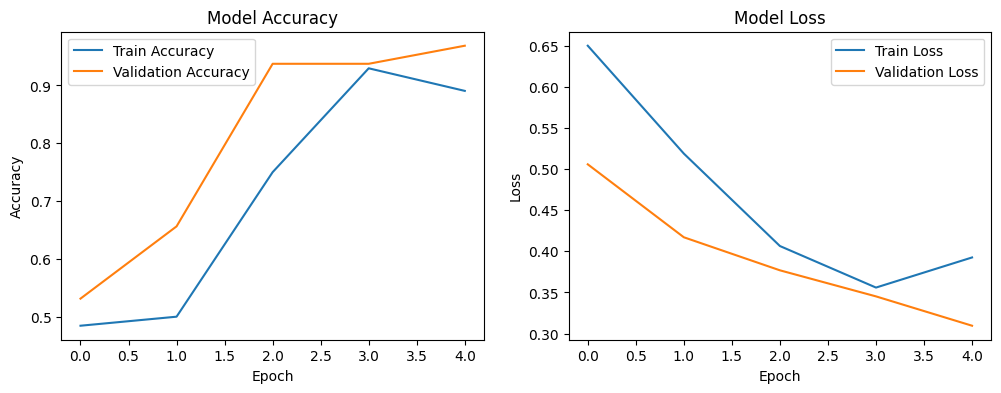

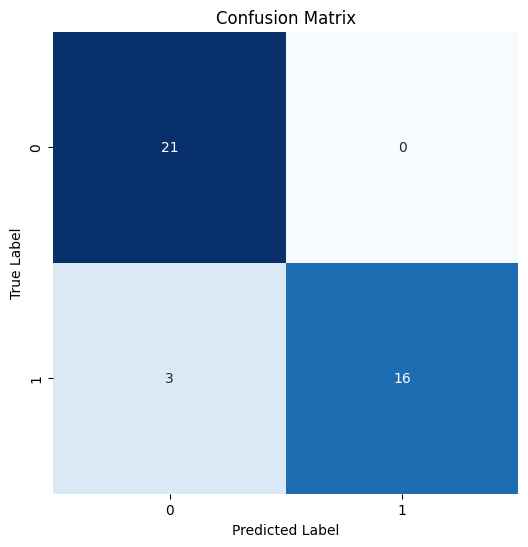

(<keras.src.callbacks.history.History at 0x7b2d4cade890>,
 [0.3278909921646118, 0.925000011920929])

In [ ]:
# Load and preprocess data for classes A and E
classes_a = ['A']
classes_e = ['E']
X_a, y_a = prepare_data_for_classification(classes_a)
X_e, y_e = prepare_data_for_classification(classes_e)

# Merge and create new labels
X = np.concatenate([X_a, X_e])
y = np.concatenate([np.zeros(len(y_a)), np.ones(len(y_e))])  # 0 for A, 1 for E

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the CNN-LSTM model
train_and_evaluate_cnn_lstm_model(X_train, y_train, X_test, y_test, filters=64, kernel_size=3, pool_size=2, lstm_units1=128, lstm_units2=128, batch_size=32, epochs=5)


B-E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 4095, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2047, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 2047, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,785 (901.50 KB)

 Trainable params: 230,785 (901.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.4812 - loss: 0.6729 - val_accuracy: 0.5312 - val_loss: 0.5279
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.4896 - loss: 0.5618 - val_accuracy: 0.5938 - val_loss: 0.4678
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5844 - loss: 0.4568 - val_accuracy: 0.8438 - val_loss: 0.3968
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.9479 - loss: 0.3234 - val_accuracy: 0.8750 - val_loss: 0.2858
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.8771 - loss: 0.3145 - val_accuracy: 0.8750 - val_loss: 0.3018


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 797ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 461ms/step - accuracy: 0.9563 - loss: 0.1674
Test loss: 0.1780126392841339
Test accuracy: 0.949999988079071
Accuracy: 0.95
Sensitivity: 0.8947368421052632
Specificity: 1.0
F1 Score: 0.9444444444444444


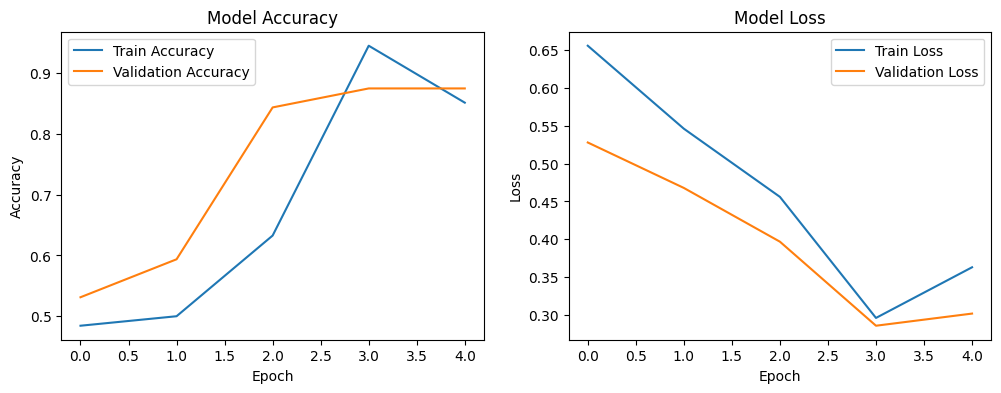

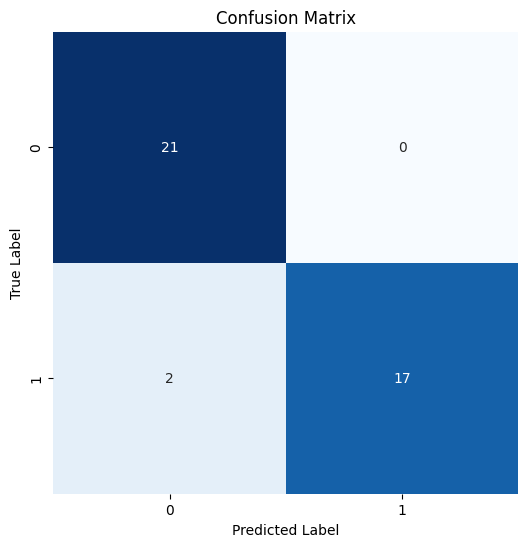

(<keras.src.callbacks.history.History at 0x7b2d3fe619c0>,
 [0.1780126392841339, 0.949999988079071])

In [ ]:
# Load and preprocess data for classes B and E
classes_b = ['B']
classes_e = ['E']
X_b, y_b = prepare_data_for_classification(classes_b)
X_e, y_e = prepare_data_for_classification(classes_e)

# Merge and create new labels
X = np.concatenate([X_b, X_e])
y = np.concatenate([np.zeros(len(y_b)), np.ones(len(y_e))])  # 0 for B, 1 for E

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the CNN-LSTM model
train_and_evaluate_cnn_lstm_model(X_train, y_train, X_test, y_test, filters=64, kernel_size=3, pool_size=2, lstm_units1=128, lstm_units2=128, batch_size=32, epochs=5)


A-C

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 4093, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2046, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 2046, 256)           │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 592,257 (2.26 MB)

 Trainable params: 592,257 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5039 - loss: 0.7028 

4/4 ━━━━━━━━━━━━━━━━━━━━ 65s 15s/step - accuracy: 0.5031 - loss: 0.7028 - val_accuracy: 0.4688 - val_loss: 0.7049
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 14s/step - accuracy: 0.5823 - loss: 0.6807 - val_accuracy: 0.5000 - val_loss: 0.6962
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 15s/step - accuracy: 0.6333 - loss: 0.6756 - val_accuracy: 0.6250 - val_loss: 0.6851
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 15s/step - accuracy: 0.7396 - loss: 0.6668 - val_accuracy: 0.5938 - val_loss: 0.6718
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 15s/step - accuracy: 0.7406 - loss: 0.6367 - val_accuracy: 0.5938 - val_loss: 0.6794
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 15s/step - accuracy: 0.6583 - loss: 0.6133 - val_accuracy: 0.5625 - val_loss: 0.7027
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 14s/step - accuracy: 0.6219 - loss: 0.6418 - val_accuracy: 0.6875 - val_loss: 0.6802
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 16s/step - accuracy: 0.7156 - loss: 0.6483 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 9/10


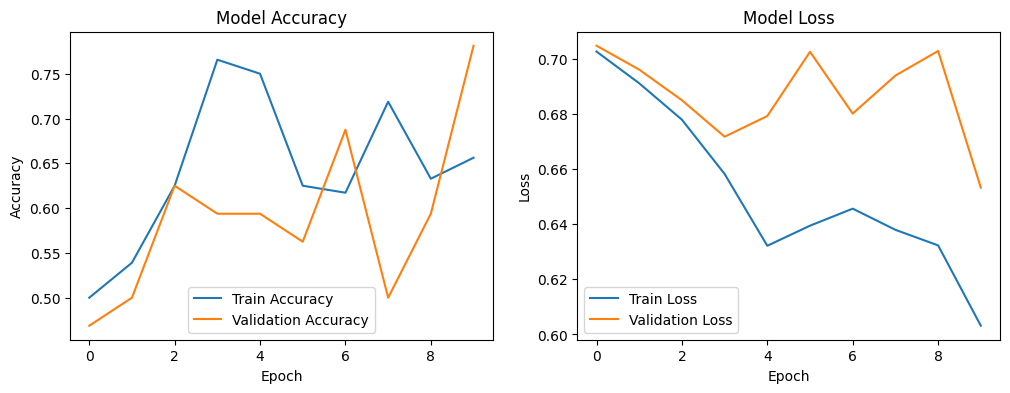

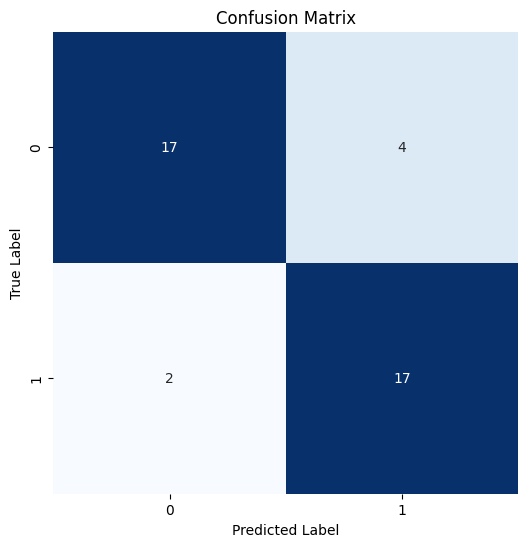

(<keras.src.callbacks.history.History at 0x7b2d3f8c1810>,
 [0.49892640113830566, 0.8500000238418579])

In [ ]:
# Load and preprocess data for classes B and D
classes_bd = ['A', 'C']
X, y = prepare_data_for_classification(classes_bd)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for CNN-LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the CNN-LSTM model
train_and_evaluate_cnn_lstm_model(X_train, y_train, X_test, y_test,
                                  filters=128, kernel_size=5,
                                  pool_size=2,
                                  lstm_units1=256, lstm_units2=128,
                                  batch_size=32,
                                  epochs=10)

B-D

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 4093, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2046, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 2046, 256)           │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 592,257 (2.26 MB)

 Trainable params: 592,257 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 16s/step - accuracy: 0.5500 - loss: 0.6921 - val_accuracy: 0.6250 - val_loss: 0.6628
Epoch 2/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 71s 15s/step - accuracy: 0.7146 - loss: 0.6351 - val_accuracy: 0.5938 - val_loss: 0.7034
Epoch 3/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 14s/step - accuracy: 0.7177 - loss: 0.5649 - val_accuracy: 0.8438 - val_loss: 0.4400
Epoch 4/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 15s/step - accuracy: 0.8000 - loss: 0.4971 - val_accuracy: 0.7812 - val_loss: 0.4738
Epoch 5/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 15s/step - accuracy: 0.8594 - loss: 0.4003 - val_accuracy: 0.9375 - val_loss: 0.2113
Epoch 6/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 14s/step - accuracy: 0.8698 - loss: 0.3380 - val_accuracy: 0.9688 - val_loss: 0.1734
Epoch 7/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 14s/step - accuracy: 0.9031 - loss: 0.2624 - val_accuracy: 0.9375 - val_loss: 0.1519
Epoch 8/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 14s/step - accuracy: 0.8865 - loss: 0.4331 - val_accuracy: 0.8438 - val_loss: 0.3918
Epoch 9/

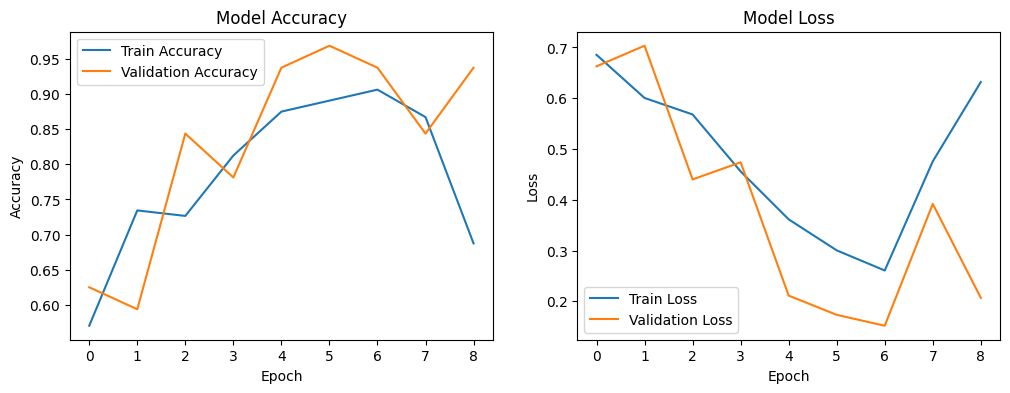

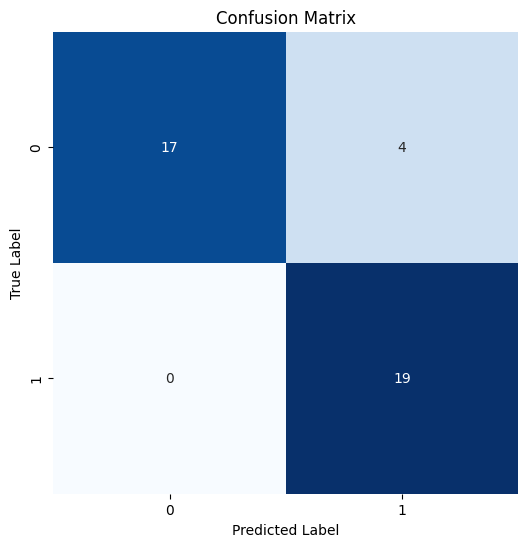

(<keras.src.callbacks.history.History at 0x7b2d32e82800>,
 [0.2521165609359741, 0.8999999761581421])

In [ ]:
# Load and preprocess data for classes B and D
classes_bd = ['B', 'D']
X, y = prepare_data_for_classification(classes_bd)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for CNN-LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the CNN-LSTM model
train_and_evaluate_cnn_lstm_model(X_train, y_train, X_test, y_test,
                                  filters=128, kernel_size=5,
                                  pool_size=2,
                                  lstm_units1=256, lstm_units2=128,
                                  batch_size=32,
                                  epochs=9)

C-E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 4095, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 2047, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 2047, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,785 (901.50 KB)

 Trainable params: 230,785 (901.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 0.6115 - loss: 0.6629 - val_accuracy: 0.5312 - val_loss: 0.4968
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.5052 - loss: 0.5379 - val_accuracy: 0.7188 - val_loss: 0.3930
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.7354 - loss: 0.4152 - val_accuracy: 0.9688 - val_loss: 0.2810
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.9375 - loss: 0.2966 - val_accuracy: 0.8750 - val_loss: 0.2885
Epoch 5/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.8844 - loss: 0.3304 - val_accuracy: 0.9375 - val_loss: 0.3826
Epoch 6/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.9083 - loss: 0.4820 - val_accuracy: 0.8438 - val_loss: 0.4190
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 0.8854 - loss: 0.4003
Test loss: 0.4605053961277008
Test accuracy: 0.875
Accuracy: 0.875
Sensitivity: 0.7894736842105263
Specificity: 0.9523809523809523
F1 Score: 0.8571428

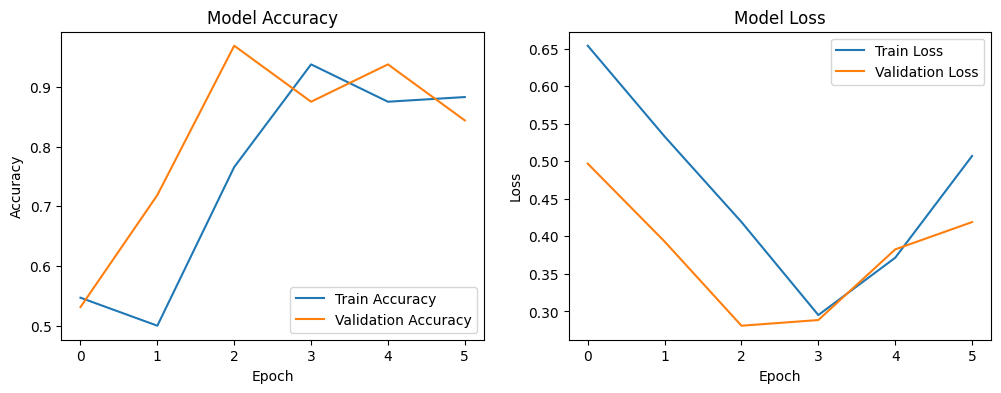

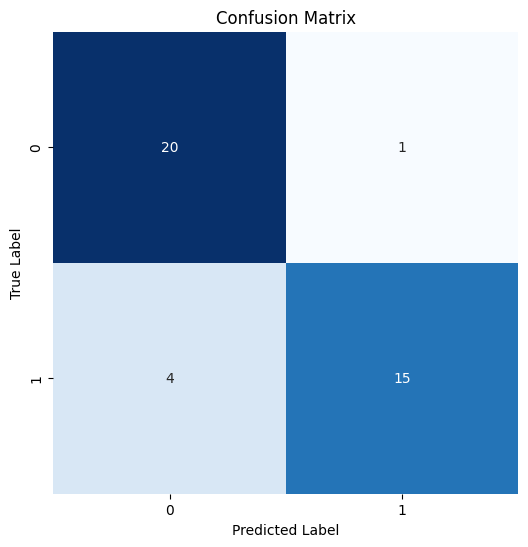

(<keras.src.callbacks.history.History at 0x7b2d2a7b5360>,
 [0.4605053961277008, 0.875])

In [ ]:
# Load and preprocess data for classes C and E
classes_ce = ['C', 'E']
X, y = prepare_data_for_classification(classes_ce)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for CNN-LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the CNN-LSTM model
train_and_evaluate_cnn_lstm_model(X_train, y_train, X_test, y_test, filters=64, kernel_size=3, pool_size=2, lstm_units1=128, lstm_units2=128, batch_size=32, epochs=6)
